In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas

import seaborn
seaborn.set_context('talk')

from sqlalchemy import create_engine, text

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2025*

----

# Trabajo práctico entregable - parte 1

En esta notebook, vamos a cargar el conjunto de datos de [la compentencia Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) sobre estimación de precios de ventas de propiedades en Melbourne, Australia.

Utilizaremos el conjunto de datos reducido producido por [DanB](https://www.kaggle.com/dansbecker). Hemos subido una copia a un servidor de la Universidad Nacional de Córdoba para facilitar su acceso remoto.

In [2]:
import plotly
plotly.__version__


'5.22.0'

In [3]:
melb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')

airbnb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv')

C:\Users\rbarone\AppData\Local\Temp\ipykernel_26724\590215205.py:4: DtypeWarning: Columns (35,77) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb_df = pandas.read_csv(


## Ejercicio 1 SQL:

1. Crear una base de datos en SQLite utilizando la libreria [SQLalchemy](https://stackoverflow.com/questions/2268050/execute-sql-from-file-in-sqlalchemy).
https://docs.sqlalchemy.org/en/14/core/engines.html#sqlite

2. Ingestar los datos provistos en 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv' en una tabla y el dataset generado en clase con datos de airbnb y sus precios por codigo postal en otra.

3. Validar tipos de columnas antes de guardar: df.to_sql() infiere tipos automáticamente, pero a veces los nombres de columnas como Date, Price o ID dan problemas si vienen con strings o valores nulos.

4. Implementar consultas en SQL que respondan con la siguiente información:

    - cantidad de registros totales por ciudad.
    - cantidad de registros totales por barrio y ciudad.
    - Consulta con filtro: ¿Cuántas propiedades hay por ciudad con más de 2 habitaciones?
    - Agregación condicional: ¿Cuál es el precio promedio de propiedades según tipo (Type) y ciudad?
    - Orden y límites: Mostrá el top 5 barrios con propiedades más caras en promedio.

5. Combinar los datasets de ambas tablas ingestadas utilizando el comando JOIN de SQL  para obtener un resultado similar a lo realizado con Pandas en clase.  



Creacion de Base de datos e ingesta

In [4]:
engine = create_engine("sqlite:///C:\\diplomatura\\to\\melbourne.db", echo=True)
# engine

melb_df.to_sql('melb', con=engine, if_exists='replace', index=False)

airbnb_df['zipcode'] = pandas.to_numeric( airbnb_df.zipcode, errors='coerce')
insertPriceAndZipcode = airbnb_df[['weekly_price','monthly_price', 'zipcode']].dropna()
insertPriceAndZipcode.to_sql('airbnb', con=engine, if_exists='replace', index=False)
airbnb_df

2025-05-14 21:00:08,918 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-14 21:00:08,923 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("melb")
2025-05-14 21:00:08,925 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:08,927 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("melb")
2025-05-14 21:00:08,928 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:08,929 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2025-05-14 21:00:08,930 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:08,931 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='view' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2025-05-14 21:00:08,932 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:08,933 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("melb")
2025-05-14 21:00:08,934 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:08,9

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,...,review_scores_location,review_scores_value,requires_license,license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,9835,https://www.airbnb.com/rooms/9835,2.018120e+13,12/7/2018,Beautiful Room & House,NaN,"House: Clean, New, Modern, Quite, Safe. 10Km f...","House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,NaN,...,9.0,9.0,f,NaN,f,strict_14_with_grace_period,f,f,1,0.04
1,10803,https://www.airbnb.com/rooms/10803,2.018120e+13,12/7/2018,Room in Cool Deco Apartment in Brunswick,A large air conditioned room with queen spring...,The apartment is Deco/Edwardian in style and h...,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,NaN,...,9.0,9.0,f,NaN,t,moderate,t,t,1,1.50
2,12936,https://www.airbnb.com/rooms/12936,2.018120e+13,12/7/2018,St Kilda 1BR APT+BEACHSIDE+VIEWS+PARKING+WIFI+AC,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,FREE WiFi FREE in-building remote controlled g...,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,First floor apartment with both lift and stair...,...,9.0,9.0,f,NaN,f,strict_14_with_grace_period,f,f,17,0.15
3,15246,https://www.airbnb.com/rooms/15246,2.018120e+13,12/7/2018,Large private room-close to city,"Comfortable, relaxed house, a home away from ...",The atmosphere is relaxed and easy going. You ...,"Comfortable, relaxed house, a home away from ...","This is a great neighbourhood – it is quiet, y...",A simple self service breakfast is available –...,...,9.0,9.0,f,NaN,f,moderate,f,f,3,0.30
4,16760,https://www.airbnb.com/rooms/16760,2.018120e+13,12/7/2018,Melbourne BnB near City & Sports,NaN,We offer comfortable accommodation in Inner Me...,We offer comfortable accommodation in Inner Me...,NaN,NaN,...,10.0,9.0,f,NaN,f,moderate,f,f,1,0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22890,30592332,https://www.airbnb.com/rooms/30592332,2.018120e+13,12/7/2018,lovely home,"near city, near tram station",NaN,"near city, near tram station",NaN,NaN,...,NaN,NaN,f,NaN,t,flexible,f,f,1,NaN
22891,30592345,https://www.airbnb.com/rooms/30592345,2.018120e+13,12/7/2018,Melton South Getaway,"Close to: Melton Rail, Coles, Coffee Lounge an...",NaN,"Close to: Melton Rail, Coles, Coffee Lounge an...",NaN,NaN,...,NaN,NaN,f,NaN,t,flexible,f,f,2,NaN
22892,30592362,https://www.airbnb.com/rooms/30592362,2.018120e+13,12/7/2018,"Glen Waverley(close to train, post, stores)近地铁...","Hi, 我是一名中国留学生. 由于暑假原因决定出租我的房间. 我会留下我所使用的物品给我的租...",NaN,"Hi, 我是一名中国留学生. 由于暑假原因决定出租我的房间. 我会留下我所使用的物品给我的租...",NaN,NaN,...,NaN,NaN,f,NaN,t,flexible,f,f,1,NaN
22893,30592590,https://www.airbnb.com/rooms/30592590,2.018120e+13,12/7/2018,Crown Jewel in the heart of Melbourne,Immaculately presented and carefully maintaine...,Security is a focus with intercom-activated en...,Immaculately presented and carefully maintaine...,A plethora of Melbourne highlights are just a ...,NaN,...,NaN,NaN,f,NaN,t,moderate,f,f,17,NaN


In [5]:
query="select * from melb"

result = pandas.read_sql_query(query, engine)
result

2025-05-14 21:00:09,542 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-14 21:00:09,543 INFO sqlalchemy.engine.Engine select * from melb
2025-05-14 21:00:09,544 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:09,645 INFO sqlalchemy.engine.Engine ROLLBACK


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,2.0,2.0,652.0,NaN,1981.0,None,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,2.0,2.0,333.0,133.0,1995.0,None,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,2.0,4.0,436.0,NaN,1997.0,None,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,1.0,5.0,866.0,157.0,1920.0,None,-37.85908,144.89299,Western Metropolitan,6380.0


In [6]:
queryTotalRegistrosPorCiudad = "select count(*) as total, regionname from melb group by Regionname order by total desc;"
resultTotalRegistrosPorCiudad = pandas.read_sql(queryTotalRegistrosPorCiudad, con=engine)
resultTotalRegistrosPorCiudad


2025-05-14 21:00:09,700 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-14 21:00:09,701 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select count(*) as total, regionname from melb group by Regionname order by total desc;")
2025-05-14 21:00:09,701 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:09,704 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select count(*) as total, regionname from melb group by Regionname order by total desc;")
2025-05-14 21:00:09,704 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:09,705 INFO sqlalchemy.engine.Engine select count(*) as total, regionname from melb group by Regionname order by total desc;
2025-05-14 21:00:09,706 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:09,717 INFO sqlalchemy.engine.Engine ROLLBACK


,total,Regionname
0,4695,Southern Metropolitan
1,3890,Northern Metropolitan
2,2948,Western Metropolitan
3,1471,Eastern Metropolitan
4,450,South-Eastern Metropolitan
5,53,Eastern Victoria
6,41,Northern Victoria
7,32,Western Victoria


In [7]:

queryTotalRegistrosPorBarrioYCiudad = "select count(*) as total, suburb from melb group by Regionname, suburb order by total desc;"
resultTotalRegistrosPorBarrioYCiudad = pandas.read_sql(queryTotalRegistrosPorBarrioYCiudad, con=engine)
resultTotalRegistrosPorBarrioYCiudad

2025-05-14 21:00:09,735 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-14 21:00:09,736 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select count(*) as total, suburb from melb group by Regionname, suburb order by total desc;")
2025-05-14 21:00:09,737 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:09,738 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select count(*) as total, suburb from melb group by Regionname, suburb order by total desc;")
2025-05-14 21:00:09,738 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:09,741 INFO sqlalchemy.engine.Engine select count(*) as total, suburb from melb group by Regionname, suburb order by total desc;
2025-05-14 21:00:09,741 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:09,761 INFO sqlalchemy.engine.Engine ROLLBACK


,total,Suburb
0,359,Reservoir
1,260,Richmond
2,249,Bentleigh East
3,239,Preston
4,222,Brunswick
...,...,...
309,1,Sandhurst
310,1,Plumpton
311,1,Rockbank
312,1,Bacchus Marsh


In [8]:
    # - Consulta con filtro: ¿Cuántas propiedades hay por ciudad con más de 2 habitaciones?
    
queryTotalRegistrosPorCiudadConMasDe2Habitaciones = "select count(*) as total, regionname from melb where rooms > 2 group by Regionname order by total desc;"
resultTotalRegistrosPorCiudadConMasDe2Habitaciones = pandas.read_sql(queryTotalRegistrosPorCiudadConMasDe2Habitaciones, con=engine)
resultTotalRegistrosPorCiudadConMasDe2Habitaciones


2025-05-14 21:00:09,790 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-14 21:00:09,791 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select count(*) as total, regionname from melb where rooms > 2 group by Regionname order by total desc;")
2025-05-14 21:00:09,793 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:09,795 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select count(*) as total, regionname from melb where rooms > 2 group by Regionname order by total desc;")
2025-05-14 21:00:09,796 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:09,798 INFO sqlalchemy.engine.Engine select count(*) as total, regionname from melb where rooms > 2 group by Regionname order by total desc;
2025-05-14 21:00:09,799 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:09,810 INFO sqlalchemy.engine.Engine ROLLBACK


,total,Regionname
0,2848,Southern Metropolitan
1,2389,Northern Metropolitan
2,2259,Western Metropolitan
3,1228,Eastern Metropolitan
4,407,South-Eastern Metropolitan
5,50,Eastern Victoria
6,39,Northern Victoria
7,31,Western Victoria


In [9]:
    # - Agregación condicional: ¿Cuál es el precio promedio de propiedades según tipo (Type) y ciudad?
queryPrecioPromedioPorTipoYCiudad = "select round(avg(price) ,2) as precio_promedio, type, regionname from melb group by type, regionname order by precio_promedio desc;"
resultPrecioPromedioPorTipoYCiudad = pandas.read_sql(queryPrecioPromedioPorTipoYCiudad, con=engine)
resultPrecioPromedioPorTipoYCiudad

2025-05-14 21:00:09,830 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-14 21:00:09,831 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select round(avg(price) ,2) as precio_promedio, type, regionname from melb group by type, regionname order by precio_promedio desc;")
2025-05-14 21:00:09,833 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:09,833 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select round(avg(price) ,2) as precio_promedio, type, regionname from melb group by type, regionname order by precio_promedio desc;")
2025-05-14 21:00:09,835 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:09,835 INFO sqlalchemy.engine.Engine select round(avg(price) ,2) as precio_promedio, type, regionname from melb group by type, regionname order by precio_promedio desc;
2025-05-14 21:00:09,836 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:09,854 INFO sqlalchemy.engine.Engine ROLLBACK


,precio_promedio,Type,Regionname
0,1802241.08,h,Southern Metropolitan
1,1205404.47,t,Southern Metropolitan
2,1197450.46,h,Eastern Metropolitan
3,1021221.87,h,Northern Metropolitan
4,955949.62,h,South-Eastern Metropolitan
5,950766.27,h,Western Metropolitan
6,913270.00,t,South-Eastern Metropolitan
7,869619.92,t,Eastern Metropolitan
8,749608.31,t,Northern Metropolitan
9,720951.05,t,Western Metropolitan


In [10]:
    # - Orden y límites: Mostrá el top 5 barrios con propiedades más caras en promedio.
queryTop5BarriosConPropiedadesMasCaras = "select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;"
resultTop5BarriosConPropiedadesMasCaras = pandas.read_sql(queryTop5BarriosConPropiedadesMasCaras, con=engine)
resultTop5BarriosConPropiedadesMasCaras


2025-05-14 21:00:09,873 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-14 21:00:09,874 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;")
2025-05-14 21:00:09,875 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:09,878 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;")
2025-05-14 21:00:09,878 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:09,880 INFO sqlalchemy.engine.Engine select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;
2025-05-14 21:00:09,881 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:09,892 INFO sqlalchemy.engine.Engine ROLLBACK


,precio_promedio,Suburb
0,2185000.00,Kooyong
1,2180240.74,Canterbury
2,2082529.41,Middle Park
3,1941355.07,Albert Park
4,1930158.00,Brighton


Ejercicio 5

In [11]:
queryJoin = "select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode"
resultJoin = pandas.read_sql(queryJoin, con=engine)
resultJoin

2025-05-14 21:00:09,910 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-14 21:00:09,911 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-14 21:00:09,912 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:09,913 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-14 21:00:09,914 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:09,915 INFO sqlalchemy.engine.Engine select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode
2025-05-14 21:00:09,917 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:00:11,745 INFO sqlalchemy.engine.Engine ROLLBACK


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,weekly_price,monthly_price
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,180.0,700.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,180.0,700.0
2,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,180.0,700.0
3,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,180.0,700.0
4,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,180.0,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188870,Yarraville,6 Agnes St,4,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,362.0,112.0,1920.0,None,-37.81188,144.88449,Western Metropolitan,6543.0,980.0,4001.0
188871,Yarraville,6 Agnes St,4,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,362.0,112.0,1920.0,None,-37.81188,144.88449,Western Metropolitan,6543.0,1070.0,3672.0
188872,Yarraville,6 Agnes St,4,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,362.0,112.0,1920.0,None,-37.81188,144.88449,Western Metropolitan,6543.0,1495.0,5550.0
188873,Yarraville,6 Agnes St,4,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,362.0,112.0,1920.0,None,-37.81188,144.88449,Western Metropolitan,6543.0,1700.0,3900.0


## Ejercicio 2 - Pandas:

1. Seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad. Justificar explicitamente las columnas seleccionadas y las que no lo fueron.
  1. Valores faltantes: ¿Qué porcentaje de filas tienen al menos un valor faltante?
  2.  Mostrar la dispersión o distribución de las columnas seleccionadas.
 3.  Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades.
 4. Mostrar visualmente los valores extremos que eliminás



2. Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico.
  1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana (porque no la media?) o el mínimo.
  2. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
  3. Mostrar un gráfico zipcode vs airbnb_price_median.
  4. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.
  5. Si las coordenadas geoespaciales estuvieran disponibles, como las usarian?

Pueden leer otras columnas del conjunto de AirBnB además de las que están en `interesting_cols`, si les parecen relevantes.

¿Qué cosas no están en los datos que te gustaría tener para predecir mejor el precio de una propiedad?

In [ ]:
#1 -Seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad. Justificar explicitamente las columnas seleccionadas y las que no lo fueron.

#Vamos a utilizar la columnas Price, Rooms, Bedroom2 y bathroom ya que tienen una buena correlacion con el precio de las propiedades

correlaciones = pandas.read_sql(queryJoin, con=engine).select_dtypes(include=[numpy.number]).corr().abs()
correlaciones['Price'].sort_values(ascending=False)

2025-05-14 21:08:41,319 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-14 21:08:41,321 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-14 21:08:41,322 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:08:41,323 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-14 21:08:41,323 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:08:41,324 INFO sqlalchemy.engine.Engine select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode
2025-05-14 21:08:41,325 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-14 21:08:43,264 INFO sqlalchemy.engine.Engine ROLLBACK


Price            1.000000
Rooms            0.642680
Bedroom2         0.628168
Bathroom         0.515244
YearBuilt        0.432079
Car              0.317481
BuildingArea     0.268765
Propertycount    0.140195
Longtitude       0.134166
Postcode         0.131246
Lattitude        0.070942
Landsize         0.040724
weekly_price     0.027755
monthly_price    0.022395
Distance         0.008231
Name: Price, dtype: float64

In [43]:
# Valores faltantes: ¿Qué porcentaje de filas tienen al menos un valor faltante?
rows = pandas.read_sql(queryJoin, con=engine)

totalValorFaltante = 0

for idx, fila in rows.iterrows():
    if fila.isnull().any():
        totalValorFaltante += 1
        continue

print(f"\nTotal de filas con al menos un valor faltante en su columna: {totalValorFaltante / len(rows) * 100:.2f}%")

2025-05-15 00:11:07,691 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-15 00:11:07,692 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-15 00:11:07,694 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-15 00:11:07,696 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-15 00:11:07,697 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-15 00:11:07,698 INFO sqlalchemy.engine.Engine select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode
2025-05-15 00:11:07,699 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-15 00:11:09,473 INFO sqlalchemy.engine.Engine ROLLBACK

Total de filas con al menos un valor faltante en su columna: 50.78%


2025-05-15 01:30:47,930 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-15 01:30:47,931 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-15 01:30:47,932 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-15 01:30:47,934 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-15 01:30:47,935 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-15 01:30:47,936 INFO sqlalchemy.engine.Engine select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode
2025-05-15 01:30:47,936 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-15 01:30:49,704 INFO sqlalchemy.engine.Engine ROLLBACK


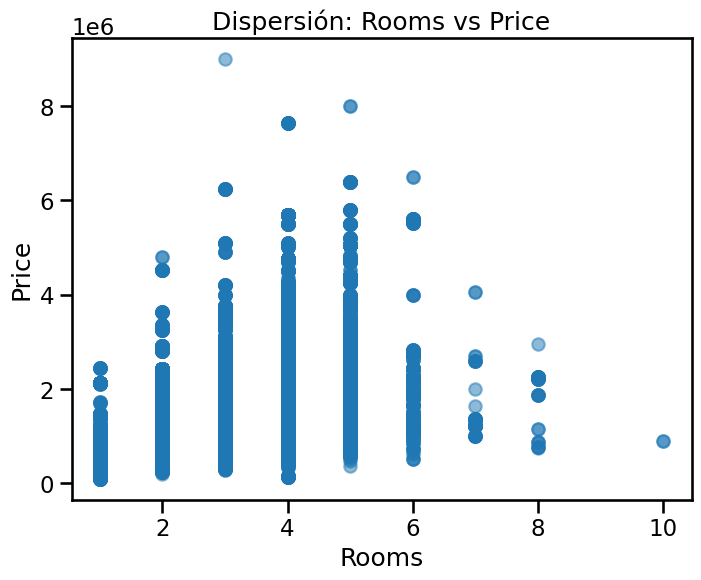

In [49]:
columnasSeleccionadas = ['Price', 'Rooms', 'Bedroom2', 'Bathroom']

result = pandas.read_sql(queryJoin, con=engine)[columnasSeleccionadas]

plt.figure(figsize=(8, 6))
plt.scatter(result['Rooms'], result['Price'], alpha=0.5)
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('Dispersión: Rooms vs Price')
plt.show()



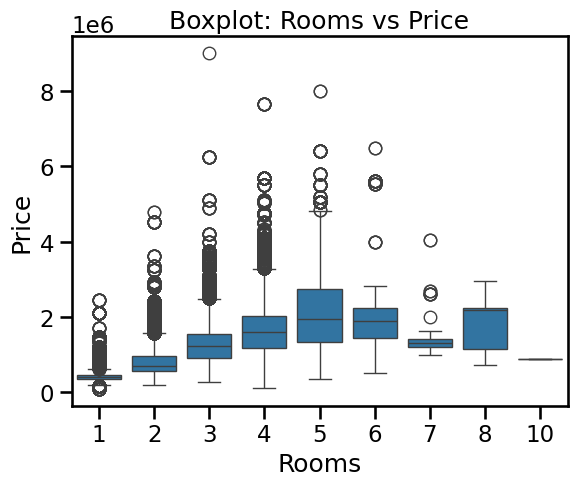

In [ ]:
seaborn.boxplot(x='Rooms', y='Price', data=result)
plt.title('Dispersion: Rooms vs Price')
plt.show()

## Ejercicio 3:

Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.

## Ejercicios opcionales:

1. Armar un script en python (archivo .py) [ETL](https://towardsdatascience.com/what-to-log-from-python-etl-pipelines-9e0cfe29950e) que corra los pasos de extraccion, transformacion y carga, armando una funcion para cada etapa del proceso y luego un main que corra todos los pasos requeridos.

2. Armar un DAG en Apache Airflow que corra el ETL. (https://airflow.apache.org/docs/apache-airflow/stable/tutorial.html)